<a href="https://colab.research.google.com/github/srinivasbharani/Advanced-Regression---Machine-Learning/blob/main/Assignment_CNN_Skin_Cancer_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [7]:
# mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [8]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/MelanomaAssignment/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/MelanomaAssignment/Test")

In [9]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2249
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [10]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [11]:
## Note used seed=123 while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2249 files belonging to 9 classes.
Using 1800 files for training.


In [12]:
## Note used seed=123 while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2249 files belonging to 9 classes.
Using 449 files for validation.


In [13]:
# List out all the classes of skin cancer and store them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### A code to visualize one instance of all the nine classes present in the dataset

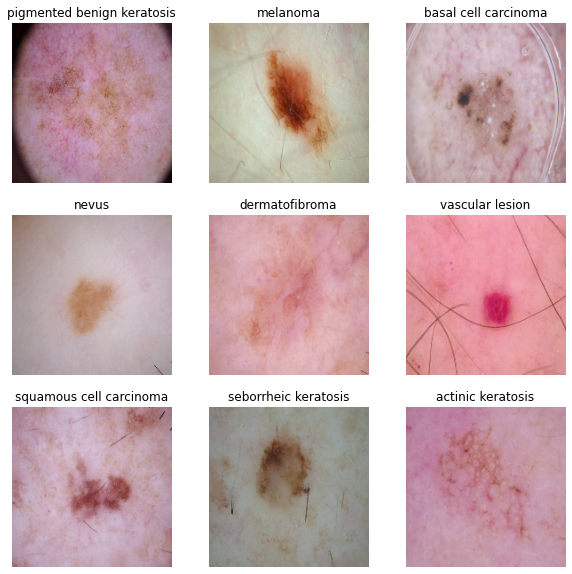

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
class_captured = []
image_count = 0
for images, labels in train_ds.take(10):
  for i in range(32):
    if class_names[labels[i]] not in class_captured:
      ax = plt.subplot(3, 3, image_count + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")
      class_captured.append(class_names[labels[i]])
      image_count +=1

In [15]:
## Standardize/Normalize the Data:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0007187794 0.76201224


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [18]:
### Your code goes here
num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [19]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

In [20]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
57/57 [==============================] - 191s 864ms/step - loss: 2.0309 - accuracy: 0.2244 - val_loss: 1.9510 - val_accuracy: 0.2272
Epoch 2/30
57/57 [==============================] - 3s 47ms/step - loss: 1.8449 - accuracy: 0.3256 - val_loss: 1.6489 - val_accuracy: 0.4232
Epoch 3/30
57/57 [==============================] - 3s 45ms/step - loss: 1.6723 - accuracy: 0.3878 - val_loss: 1.5695 - val_accuracy: 0.4454
Epoch 4/30
57/57 [==============================] - 3s 45ms/step - loss: 1.5474 - accuracy: 0.4506 - val_loss: 1.5827 - val_accuracy: 0.4343
Epoch 5/30
57/57 [==============================] - 3s 45ms/step - loss: 1.5065 - accuracy: 0.4789 - val_loss: 1.6427 - val_accuracy: 0.4298
Epoch 6/30
57/57 [==============================] - 3s 45ms/step - loss: 1.4397 - accuracy: 0.5006 - val_loss: 1.4468 - val_accuracy: 0.4944
Epoch 7/30
57/57 [==============================] - 3s 45ms/step - loss: 1.3819 - accuracy: 0.5111 - val_loss: 1.4552 - val_accuracy: 0.5234
Epoch 8/30

In [21]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        1

### Visualizing training results

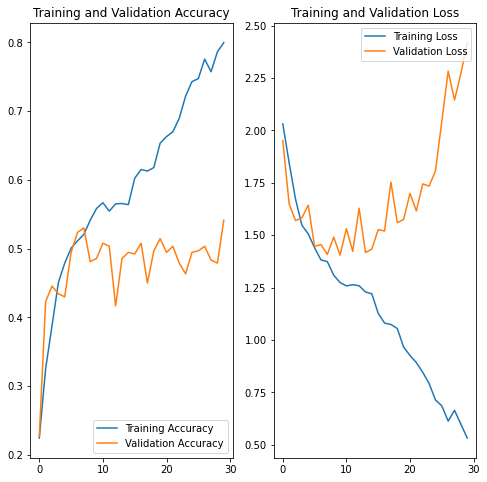

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### We can clearly see that the model is Overfitting, based on the fact that the accuracy of training is ~80% and accuracy on validation set is ~54%

In [23]:
data_augmentation = keras.Sequential (
    [
     layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
     layers.experimental.preprocessing.RandomRotation(0.1),
     layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

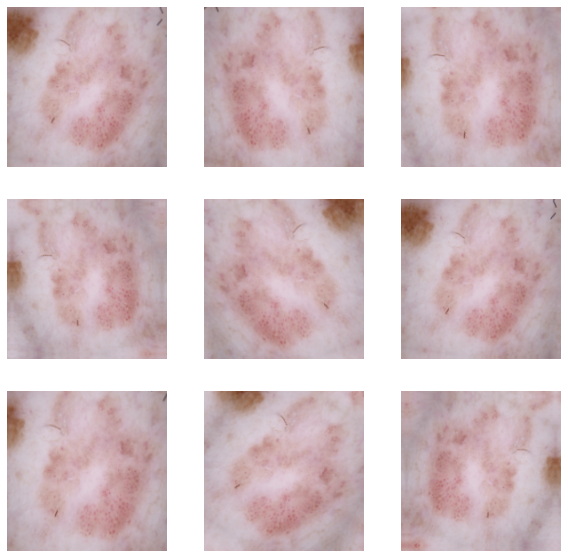

In [24]:
# Visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3,3, i+1)
    plt.imshow(augmented_images[0].numpy().astype('uint8'))
    plt.axis('off')



### Create the model, compile and train the model


In [25]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

num_classes = 9

model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])



### Compiling the model

In [26]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [27]:
## Your code goes here, note: train your model for 20 epochs
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
57/57 [==============================] - 5s 56ms/step - loss: 1.9938 - accuracy: 0.2517 - val_loss: 1.8800 - val_accuracy: 0.2829
Epoch 2/30
57/57 [==============================] - 3s 50ms/step - loss: 1.7885 - accuracy: 0.3600 - val_loss: 1.7782 - val_accuracy: 0.2851
Epoch 3/30
57/57 [==============================] - 3s 51ms/step - loss: 1.7048 - accuracy: 0.3700 - val_loss: 1.6014 - val_accuracy: 0.4187
Epoch 4/30
57/57 [==============================] - 3s 51ms/step - loss: 1.5978 - accuracy: 0.4072 - val_loss: 1.5780 - val_accuracy: 0.4343
Epoch 5/30
57/57 [==============================] - 3s 50ms/step - loss: 1.5412 - accuracy: 0.4522 - val_loss: 1.5912 - val_accuracy: 0.4365
Epoch 6/30
57/57 [==============================] - 3s 51ms/step - loss: 1.4423 - accuracy: 0.4967 - val_loss: 1.5443 - val_accuracy: 0.4610
Epoch 7/30
57/57 [==============================] - 3s 50ms/step - loss: 1.4266 - accuracy: 0.4944 - val_loss: 1.4701 - val_accuracy: 0.4900
Epoch 8/30
57

### Visualizing the results

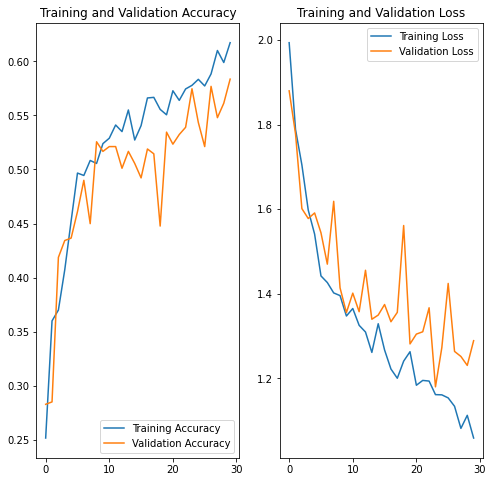

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The model now is somewhat ok, and is doing much better than previous model - although the accurancy is still 60%

#### Finding the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

                            count  percentage
pigmented benign keratosis    472        21.0
melanoma                      438        19.5
basal cell carcinoma          376        16.7
nevus                         357        15.9
squamous cell carcinoma       181         8.0
vascular lesion               139         6.2
actinic keratosis             114         5.1
dermatofibroma                 95         4.2
seborrheic keratosis           77         3.4


([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text major ticklabel objects>)

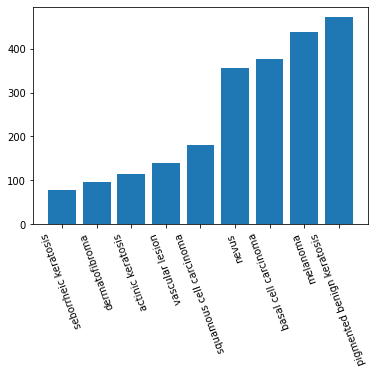

In [29]:
## Your code goes here.
class_count = {}
path_to_training_dataset = "/content/drive/MyDrive/Colab Notebooks/MelanomaAssignment/Train"
for i in class_names :
  data_dir = pathlib.Path(path_to_training_dataset + '/' + i)
  image_count = len(list(data_dir.glob('*.jpg')))
  # len(list(data_dir_train.glob('*/*.jpg')))
  class_count[i] = image_count

df = pd.DataFrame(class_count.values(), index=class_count.keys(), columns=['count'])
df['percentage'] = round(100*df['count']/df['count'].sum(), 1)
print(df.sort_values(by=['count'], ascending=False))

class_count ={k: v for k, v in sorted(class_count.items(), key=lambda item: item[1])}
plt.bar(class_count.keys(), height=class_count.values())
plt.xticks(rotation = 110)


Some Classes like 'Pigmented benign keratosis' is on higher side, and 'seborrheic keratosis' is having less samples


#### To Rectify the class imbalance
#### **Context:** We can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [30]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [31]:
path_to_training_dataset="/content/drive/MyDrive/Colab Notebooks/MelanomaAssignment/Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + "/" +i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/MelanomaAssignment/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCED0814F10>: 100%|██████████| 500/500 [00:28<00:00, 17.68 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/MelanomaAssignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCF4A0CED10>: 100%|██████████| 500/500 [00:28<00:00, 17.54 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/MelanomaAssignment/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCF401305D0>: 100%|██████████| 500/500 [00:29<00:00, 17.11 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/MelanomaAssignment/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FCED06EF090>: 100%|██████████| 500/500 [01:48<00:00,  4.62 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/MelanomaAssignment/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCED0777410>: 100%|██████████| 500/500 [01:45<00:00,  4.73 Samples/s]


Initialised with 472 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/MelanomaAssignment/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FCED078A390>: 100%|██████████| 500/500 [00:24<00:00, 20.26 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/MelanomaAssignment/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FCED0814F10>: 100%|██████████| 500/500 [00:54<00:00,  9.11 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/MelanomaAssignment/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCECC467290>: 100%|██████████| 500/500 [00:24<00:00, 20.56 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/MelanomaAssignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCED07AF8D0>: 100%|██████████| 500/500 [00:24<00:00, 20.66 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/Colab Notebooks/MelanomaAssignment/Train/melanoma/output/melanoma_original_ISIC_0010322.jpg_703e3679-c528-4cd5-83dd-269316d66d0c.jpg',
 '/content/drive/MyDrive/Colab Notebooks/MelanomaAssignment/Train/melanoma/output/melanoma_original_ISIC_0011045.jpg_d894f39c-300c-44d9-9420-6ecdb323e701.jpg',
 '/content/drive/MyDrive/Colab Notebooks/MelanomaAssignment/Train/melanoma/output/melanoma_original_ISIC_0000516.jpg_9cacd64e-efe1-4255-b2d7-8cc1081c33b9.jpg',
 '/content/drive/MyDrive/Colab Notebooks/MelanomaAssignment/Train/melanoma/output/melanoma_original_ISIC_0000160.jpg_d5619987-1a5d-471b-bc9d-4895e3fed29a.jpg',
 '/content/drive/MyDrive/Colab Notebooks/MelanomaAssignment/Train/melanoma/output/melanoma_original_ISIC_0000172.jpg_c0c6897e-6890-4200-8f92-54d7524abf71.jpg',
 '/content/drive/MyDrive/Colab Notebooks/MelanomaAssignment/Train/melanoma/output/melanoma_original_ISIC_0011158.jpg_6851f61b-7d33-48ef-80d1-3ca96bb012d7.jpg',
 '/content/drive/MyDrive/Colab Notebooks

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [35]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [36]:
original_df = []
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df.append(df2)

In [37]:
new_df['Label'].value_counts()

melanoma                      500
vascular lesion               500
basal cell carcinoma          500
squamous cell carcinoma       500
nevus                         500
pigmented benign keratosis    500
actinic keratosis             500
seborrheic keratosis          500
dermatofibroma                500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [38]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [39]:
data_dir_train=pathlib.Path("/content/drive/MyDrive/Colab Notebooks/MelanomaAssignment/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 5400 files for training.


#### Create a validation dataset

In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 1349 files for validation.


#### Create your model (make sure to include normalization)

In [50]:
num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


#### Compile your model (Choose optimizer and loss function appropriately)

In [51]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

####  Train your model

In [52]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 41s 233ms/step - loss: 1.8088 - accuracy: 0.2859 - val_loss: 1.5681 - val_accuracy: 0.3706
Epoch 2/30
169/169 [==============================] - 39s 222ms/step - loss: 1.4799 - accuracy: 0.4400 - val_loss: 1.3720 - val_accuracy: 0.5107
Epoch 3/30
169/169 [==============================] - 40s 230ms/step - loss: 1.3588 - accuracy: 0.4865 - val_loss: 1.3824 - val_accuracy: 0.4937
Epoch 4/30
169/169 [==============================] - 40s 226ms/step - loss: 1.2489 - accuracy: 0.5261 - val_loss: 1.2677 - val_accuracy: 0.5271
Epoch 5/30
169/169 [==============================] - 40s 226ms/step - loss: 1.1779 - accuracy: 0.5544 - val_loss: 1.1119 - val_accuracy: 0.5812
Epoch 6/30
169/169 [==============================] - 40s 227ms/step - loss: 1.1092 - accuracy: 0.5880 - val_loss: 1.0472 - val_accuracy: 0.6175
Epoch 7/30
169/169 [==============================] - 40s 226ms/step - loss: 0.9843 - accuracy: 0.6304 - val_loss: 0.9988 - val_ac

#### Visualize the model results

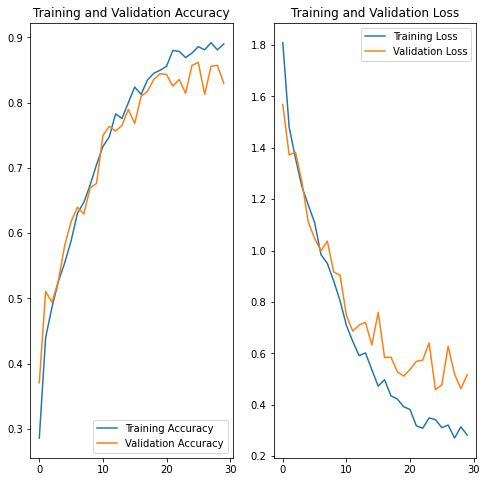

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyzing the results here. 



In [56]:
### There is still a very slight bit of Overfitting, however there has been significant improvement due to class rebalance - and we can say the model is performing largely ok

In [58]:


test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_test,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)
print(test_ds.class_names)

normalised_layer = tf.keras.layers.Rescaling(1./255)
test_ds1 = test_ds.map(lambda x, y: (normalised_layer(x), y))

model.evaluate(test_ds1)
model.evaluate(test_ds)
model.evaluate(train_ds)
model.evaluate(val_ds)


Found 118 files belonging to 9 classes.
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
43/43 [==============================] - 8s 150ms/step - loss: 0.5167 - accuracy: 0.8295


[0.5167262554168701, 0.8295033574104309]